# Derivativos de Taxa de Juros
## Modelo de Kalotay-Williams-Fabozzi

Renato Mori, Uirá Caiado. 19 de Junho, 2016

**Resumo**

*Neste projeto vamos implementar um modelo de um fator chamado [Kalotay-Williams-Fabozzi](https://en.wikipedia.org/wiki/Short-rate_model#One-factor_short-rate_models), onde apenas um único fator estocástico - a taxa de juros instantânea - determina a evolução de toda estrutura a termo da taxa de juros. Vamos descrever brevemente o modelo, detalhar sua implementação, estimar seus parâmetros e demonstrar sua utilização para precificação de alguns títulos que sejam possíveis de compara com preços de mercado.*

## 1. Introdução

Nesta sessão vamos introduzir o modelo discutido neste trabalho e descrever o problema que será abordado aqui.


### 1.1. Modelagem da Curva de Juros

Como colocado por Fabozzi, a Taxa de Juros frequentemente é modelada usando equações diferenciais estocásticas ([SDEs](https://en.wikipedia.org/wiki/Stochastic_differential_equation) é a abreviação em inglês). Os modelos mais comumente utilizados são os modelos de um ou dois fatores (estocástios), sendo que o de um usa uma SDE para representar a taxa de juros de curto prazo e a segunda representa tanto a taxa de curto como a de longo prazo. Na dinâmica escolhida para o modelo que deve ser refletidas as características desejadas para a curva, como reversão a média e volatilidade dependente do nível da taxa.

Existe duas abordagens para na utilizaçtão de equações estocásticas na modelagem da curva a termo de juros: modelos de equilibrio e modelos de não arbitragem, sendo que ambos são usados para precificar *Bonds* e derivativos sobre taxa de juros.

Modelos de equilíbrio começam com uma SDE e desenvolvem uma estrutura que não necessariamente correspondem aos preços observados no mercado. Alguns exemplos de modelos desta classe são o Vasicek, Brenna and Schwartz e o Cox, Ingersoll and Ross.

Os modelos de não arbitragem também utilizam uma SDE, porém usam os preços de mercado para gerar os caminhos possíveis para taxa de juros. Esta estrutura segue as características impostas pela SDE as taxas de juros encontradas, quando usadas para precificar um bond qualquer, resultam na mesma taxa de juros observada no mercado. Exemplos são o Ho and Lee, Black, Derman and Toy e o Hull and White.

Os modelos de não arbitragem geralmente são escolhidos para precificação de Bonds e derivativos pois garantem que as taxas atuais correspondam ao mercado. Este trabalgho explorará um modelo de não arbitragem chamado Kalotay-Williams-Fabozzi.

### 1.2. Modelo Kalotay-Williams-Fabozzi

O modelo Kalotay-Williams-Fabozzi (KWF) assume que as mudanças na taxa de juros de curto prazo segue um certo [processo estocástico](https://en.wikipedia.org/wiki/Stochastic_process) que pode ser descrito pela seguinte SDE:

$$ \mathrm{d} \ln \left (  r(t) \right ) = \theta(t) \mathrm{d} t + \sigma\mathrm{d}Z$$

Onde $Z$ é um processo de [Wiener](https://en.wikipedia.org/wiki/Wiener_process), $\theta$ é o *drift* do processo e $\sigma$ é a volatilidade da primeira diferença das taxas de curto prazo.  Como o que a equação descreve é a dinâmica do **logarítimo natural** de taxa $r$; e $W$ tem distribuição normal, o $\ln(r)$ terá distribuição normal e o $r$, log normal. Desta maneira, embora $\ln(r)$ possa assumir valores negativos, $r$ não assumirá.

No trabalho original em que o modelo KWF foi apresentado, os autores não incluiram explicitamente o *drift* na dinâmica do processo na modelagem e, por tanto, também não utilizaremos ele aqui. Assim, assumindo $\theta=0$, integrando ambos os lados da SDE, chamando $\ln(r)$ de $f(t)$ e sabendo que $W_t - W_s = W_{t-s}$, ficamos com:

\begin{equation}
    \begin{aligned}
    \int_{t}^{T}{\mathrm{d} f(t)} &=  \sigma \int_{t}^{T}{\mathrm{d}W_{t}} \\
    f(T) - f(t) &= \sigma \left (  W_{T} - W_{t} \right ) \\
    \ln \left (  r(T) \right ) - \ln \left (  r(t) \right ) &= \sigma \left (  W_{T} - W_{t} \right )\\
    r(T) &= r(t) \cdot e^{\sigma \cdot W_{T-t}}
    \end{aligned}
\end{equation}

Na proxima seção, discretizaremos este processo.

## 2. Implementando o Modelo

Nesta sessão detalharemos e implementaremos o modelo utilizando como referência o artigo original e calibraremos ele para que bata com os dados de mercado.

### 2.1. Aproximação da SDE por Árvore Binomial

As equações diferenciais estocásticas podem ter sua solução aproximada numericamente utilizando uma árvore binomial. Este método assume que a taxa de juros de curto prazo pode assumir apenas dois valores no período seguinte da discretização, $r_{u}$ ou $r_{d}$, onde $r_{u} > r_{d}$. Como cada nó da árvore dá origem à dois novos nós, a medida que se aumenta os passos de discretização, o número de nós rapidamente aumenta. Para evitar este crescimento exponencial, é imposto ao modelo que a árvore seja recombinante, ou seja, um movimento de subida seguido por uma queda resulta no mesmo nó de uma queda seguida de uma alta. 

Um movimento de alta na taxa de juros tem probabilidade $q$ de ocorrer, enquanto um de queda tem probabilidade de $1 - q$. Utilizaremos probabilidade de $q=0.5$ para garantir a netralidade a risco na solução da SDE. É importante frisar que isso não implica na probabilidade real da taxa de juros cair. $q$ representa apenas a probabilidade *neutra a risco*. 

In [66]:
# bibliotecas necessarias
import numpy as np
import math
import pandas as pd
import seaborn as sns
import matplotlib.pylab as plt

In [216]:
import time
import binomial_tree; reload(binomial_tree);

def foo(i):
    f_start = time.time()
    x = binomial_tree.BinomialTree(i)
    x._go_foward(i)
    i_rtn = len(x.set_of_nodes)
    return i_rtn, time.time() - f_start

print "Tempo para inicar toda a arvore: "
for i in [10, 100, 250, 500, 1000]:
    # mais de 1000 nodes trava
    i_nodes, f_time = foo(i)
    print "- Com {} passos: Criados {:0,.0f} em {:.2f} segundos".format(i, i_nodes, f_time)

Tempo para inicar toda a arvore: 
- Com 10 passos: Criados 55 em 0.00 segundos
- Com 100 passos: Criados 5,050 em 0.10 segundos
- Com 250 passos: Criados 31,375 em 0.63 segundos
- Com 500 passos: Criados 125,250 em 2.24 segundos
- Com 1000 passos: Criados 500,500 em 10.16 segundos


In [69]:
import binomial_tree; reload(binomial_tree);
x = binomial_tree.BinomialTree(12)
x._go_foward(12)
print 'Primeiros passos da arvore criada:\n========================================\n\n'
print x

Primeiros passos da arvore criada:


								UUUUUUUU
							UUUUUUU	
						UUUUUU		DUUUUUUU
					UUUUU		DUUUUUU	
				UUUU		DUUUUU		DDUUUUUU
			UUU		DUUUU		DDUUUUU	
		UU		DUUU		DDUUUU		DDDUUUUU
	U		DUU		DDUUU		DDDUUUU	
_		DU		DDUU		DDDUUU		DDDDUUUU
	D		DDU		DDDUU		DDDDUUU	
		DD		DDDU		DDDDUU		DDDDDUUU
			DDD		DDDDU		DDDDDUU	
				DDDD		DDDDDU		DDDDDDUU
					DDDDD		DDDDDDU	
						DDDDDD		DDDDDDDU
							DDDDDDD	
								DDDDDDDD

Plotted 8 from 12 steps


In [70]:
import binomial_tree; reload(binomial_tree)
import pandas as pd
# definindo parametros
l_txindicativa = [14.152, 14.0265, 13.7596, 13.4663, 13.1995,
                  12.9729, 12.8001, 12.7250, 12.6541, 12.5649,
                  12.5653, 12.6005]
l_prazo = [9., 74., 136., 199., 260., 324., 385., 446., 509, 635., 758., 888.]
l_txindicativa = [x/100. for x in l_txindicativa]

In [71]:
# testa tempo
def foo():
    my_tree = binomial_tree.KWFTree([x for x in l_txindicativa],
                                    [x/252. for x in l_prazo])
    my_tree.fit_foward_curve(f_sigma=0.1)
    
%timeit foo()

1 loop, best of 3: 818 ms per loop


In [72]:
#cria arvore
import binomial_tree; reload(binomial_tree)
my_tree = binomial_tree.KWFTree([x for x in l_txindicativa],
                                [x/252. for x in l_prazo])
my_tree.fit_foward_curve(f_sigma=0.1, f_faceval=1000.)
self = my_tree

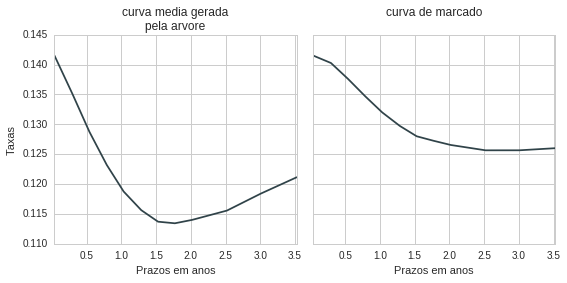

In [73]:
my_tree.plot_curves();

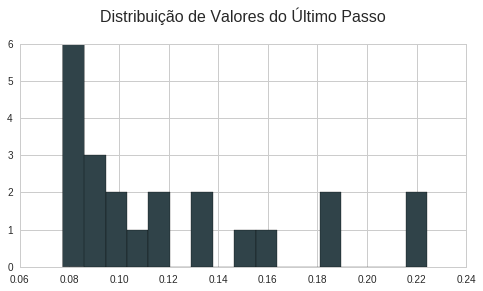

In [74]:
my_tree.plot_hist();

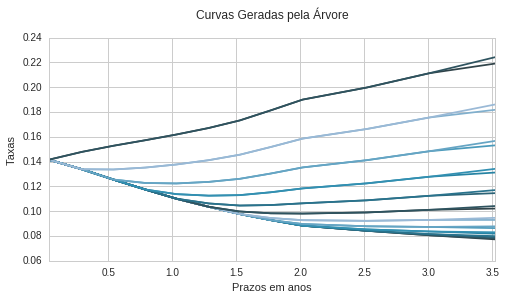

In [75]:
my_tree.plot_lattice();

In [79]:
my_tree.get_description()

                 cupon     valor     taxa      prazo     
_                 0.00   658.236    14.152    0.0357
D                 0.00   686.853    12.623    0.0357
U                 0.00   635.858    15.417    0.0357
DD                0.00   731.192    10.915    0.2579
DU                0.00   685.285    13.332    0.2579
UU                0.00   634.344    16.284    0.2579
DDD               0.00   770.468     9.396    0.2460
DDU               0.00   729.669    11.476    0.2460
DUU               0.00   683.760    14.017    0.2460
UUU               0.00   632.902    17.121    0.2460
DDDD              0.00   805.822     8.140    0.2500
...


In [80]:
#cria arvore
import binomial_tree; reload(binomial_tree)
my_tree = binomial_tree.KWFTreePU([x for x in l_txindicativa],
                                [x/252. for x in l_prazo])
my_tree.fit_foward_curve(f_sigma=0.1, f_faceval=1000.)
self = my_tree
df = my_tree.get_lattice()

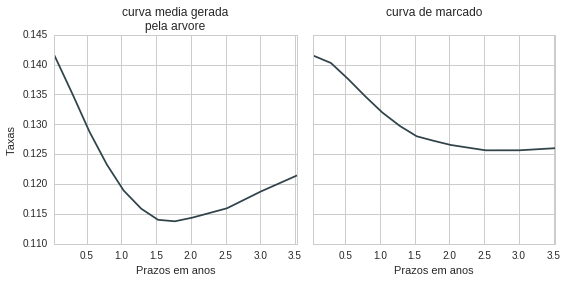

In [81]:
my_tree.plot_curves();

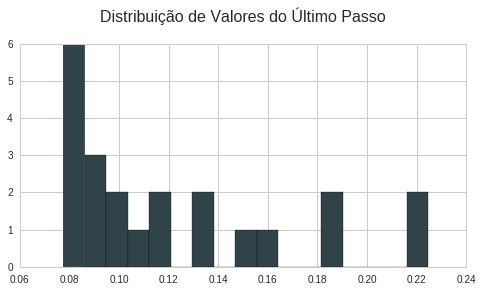

In [82]:
my_tree.plot_hist();

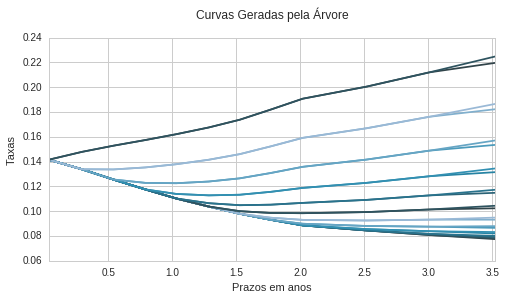

In [83]:
my_tree.plot_lattice();

In [84]:
my_tree.get_description()

                 cupon     valor     taxa      prazo     
_                 0.00   658.236    14.152    0.0357
D                 0.00   686.853    12.623    0.0357
U                 0.00   635.858    15.417    0.0357
DD                0.00   731.192    10.915    0.2579
DU                0.00   685.285    13.332    0.2579
UU                0.00   634.344    16.284    0.2579
DDD               0.00   770.468     9.396    0.2460
DDU               0.00   729.669    11.476    0.2460
DUU               0.00   683.760    14.017    0.2460
UUU               0.00   632.902    17.121    0.2460
DDDD              0.00   805.822     8.140    0.2500
...


Testando códigos para precificação do Bond proposto pelo paper

In [113]:
# dados originais do paper
l_txindicativa = [0.035, 0.04, 0.045]
l_prazo = [1., 2., 3.]

my_tree = binomial_tree.KWFTree(l_txindicativa, l_prazo)
my_tree.fit_foward_curve(f_sigma=0.1, f_faceval=100.)
print my_tree

			UUU
		UU	
	U		DUU
_		DU	
	D		DDU
		DD	
			DDD



In [112]:
my_tree.get_description()

                 cupon     valor     taxa      prazo     
_                 0.00   100.000     3.500    1.0000
D                 4.50    99.926     4.074    1.0000
U                 4.50    98.074     4.976    1.0000
DD                4.50    99.972     4.530    1.0000
DU                4.50    99.022     5.532    1.0000
UU                4.50    97.886     6.757    1.0000
DDD               4.50   100.000     0.000    1.0000
DDU               4.50   100.000     0.000    1.0000
DUU               4.50   100.000     0.000    1.0000
UUU               4.50   100.000     0.000    1.0000


In [114]:
import instruments; reload(instruments);
bond_example = instruments.Bond(f_face_value=100., f_cupon=5.25)

In [116]:
bond_example.get_current_value(my_tree, i_steps=3)

102.07456540525168

Testo com valores da planilha, fitando curva da maneira do jeito do paper

In [117]:
l_txindicativa = [14.152, 14.0265, 13.7596, 13.4663, 13.1995,
                  12.9729, 12.8001, 12.7250, 12.6541, 12.5649,
                  12.5653, 12.6005]
l_prazo = [9., 74., 136., 199., 260., 324., 385., 446., 509, 635., 758., 888.]
l_txindicativa = [x/100. for x in l_txindicativa]

In [118]:
my_tree = binomial_tree.KWFTree([x for x in l_txindicativa],
                                [x/252. for x in l_prazo])
my_tree.fit_foward_curve(f_sigma=0.1, f_faceval=1000.)

In [119]:
import instruments; reload(instruments);
bond_example = instruments.Bond(f_face_value=1000., f_cupon=0.)

In [125]:
for i in xrange(1, 13):
    print "{}: {:5.5f}".format(i, bond_example.get_current_value(my_tree, i_steps=i))

1: 995.28399
2: 962.18877
3: 932.81297
4: 905.13473
5: 880.11516
6: 855.17478
7: 832.39269
8: 809.51780
9: 786.74483
10: 742.89192
11: 701.18197
12: 658.78551


Testo com valores da planilha, fitando pelo PU

In [127]:
my_tree = binomial_tree.KWFTreePU([x for x in l_txindicativa],
                                  [x/252. for x in l_prazo])
my_tree.fit_foward_curve(f_sigma=0.1, f_faceval=1000.)

In [128]:
for i in xrange(1, 13):
    print "{}: {:5.5f}".format(i, bond_example.get_current_value(my_tree, i_steps=i))

1: 995.28399
2: 962.18859
3: 932.79073
4: 905.05000
5: 879.92598
6: 854.85059
7: 831.92223
8: 808.97002
9: 786.10266
10: 742.11741
11: 700.45207
12: 658.23615


#### TODO:
- Implementar (OK)
- Levantar os preços histórico dos títulos: NTB (OK)
- Apresentar os principais pontos da abordagem (hipóteses, limitações e etc)
- detalhar o processo de calibração (juros e vol)
- Detalhar a determiação dos parâmetros do modelo ($\sigma$)
- Checar se tem base de dados de opções (Call Européia) de Juros
- Demonstrar a precificação de 2 derivativos mais complexos (opcional compara com mercado)


## 2. Bla

bla bla

### 2.1. Bla

bla bla

## 3. Conclusão

bla bla

## 4. Últimas Considerações

bla bla

*Style notebook and change matplotlib defaults*

In [8]:
#loading style sheet
from IPython.core.display import HTML
HTML(open('ipython_style.css').read())

In [9]:
#changing matplotlib defaults
%matplotlib inline
import seaborn as sns
sns.set_palette("deep", desat=.6)
sns.set_context(rc={"figure.figsize": (8, 4)})
sns.set_style("whitegrid")
sns.set_palette(sns.color_palette("PuBuGn_d", 10))